In [1]:
import pygplates
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr

import paleogeography as pg
reload(pg)

%matplotlib inline



basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'

time = 76.
sampling = 1.0

rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % basedir,
                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % basedir])

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,time)



In [154]:
env_list = ['lm','m','sm','i']

pg_features = pg.load_paleogeography(pg_dir,env_list)

pg_reconstructed = []
pygplates.reconstruct(pg_features,rotation_model,pg_reconstructed,time)


['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/lm_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/sm_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/i_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


In [155]:
# This was an abandoned attempt to clean up the extracted paleoshorelines from
# 
def distance_to_shoreline(pg_reconstructed):
    pShoreline = []
    pLon = []
    pLat = []

    for feature in pg_reconstructed:
        if feature.get_feature().get_shapefile_attribute('Layer') == 'lm':
            print 'working on feature....'
            tessellated_boundary = feature.get_reconstructed_geometry().to_tessellated(np.radians(5.0))

            for point in tessellated_boundary.get_points():

                min_distance_to_features = None

                for feature2 in pg_reconstructed: 
                    if feature2.get_feature().get_shapefile_attribute('Layer') == 'sm':
                        for polygon2 in feature2.get_reconstructed_geometry():

                            distance_to_feature = pygplates.GeometryOnSphere.distance(point,
                                                                                      polygon2,
                                                                                      min_distance_to_features)

                            if distance_to_feature is not None:
                                min_distance_to_features = distance_to_feature

                #if min_distance_to_features < np.radians(0.05):
                pShoreline.append(min_distance_to_features)
                #else:
                    #pShoreline.append(0.)
                pLon.append(point.to_lat_lon()[1])
                pLat.append(point.to_lat_lon()[0])
                                                    


['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/lm_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_76Ma/i_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


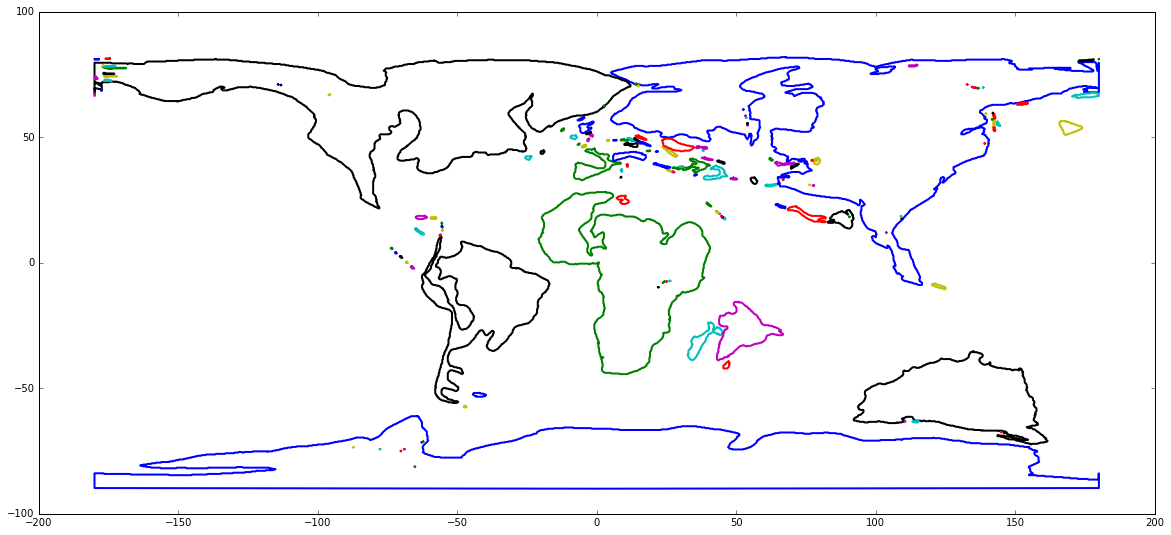

In [156]:
import polygon_processing as pp
reload(pp)

env_list = ['lm','m','i']
pg_features = pg.load_paleogeography(pg_dir,env_list)


cf = pp.merge_polygons(pg_features,rotation_model,time=time,sampling=0.25)

plt.figure(figsize=(20,9))
for n, contour in enumerate(cf):
    plt.plot(contour.get_geometry().to_lat_lon_array()[:, 1], 
             contour.get_geometry().to_lat_lon_array()[:, 0], linewidth=2)


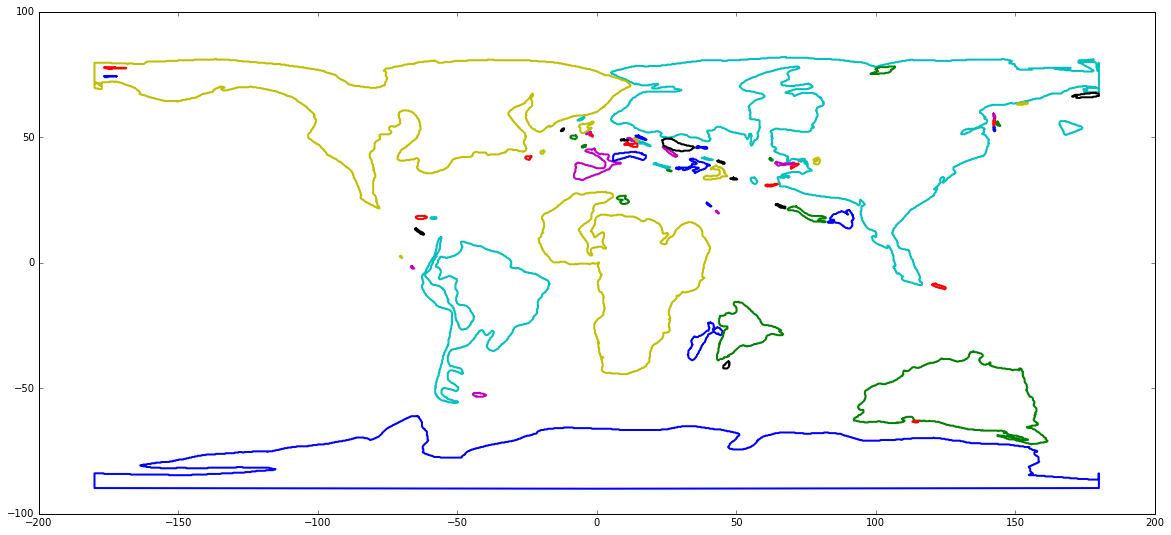

In [157]:
area_threshold = 0.0001

sieve_polygons = pp.polygon_area_threshold(cf,area_threshold)

plt.figure(figsize=(20,9))
for n, contour in enumerate(sieve_polygons):
    plt.plot(contour.get_geometry().to_lat_lon_array()[:, 1], 
             contour.get_geometry().to_lat_lon_array()[:, 0], linewidth=2)
    
pygplates.FeatureCollection(sieve_polygons).write('Paleoshoreline_255.gpmlz')

In [158]:
static_polygons = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz'

cc_features = pygplates.partition_into_plates(static_polygons,
                                              rotation_model,
                                              sieve_polygons,
                                              reconstruction_time=time)


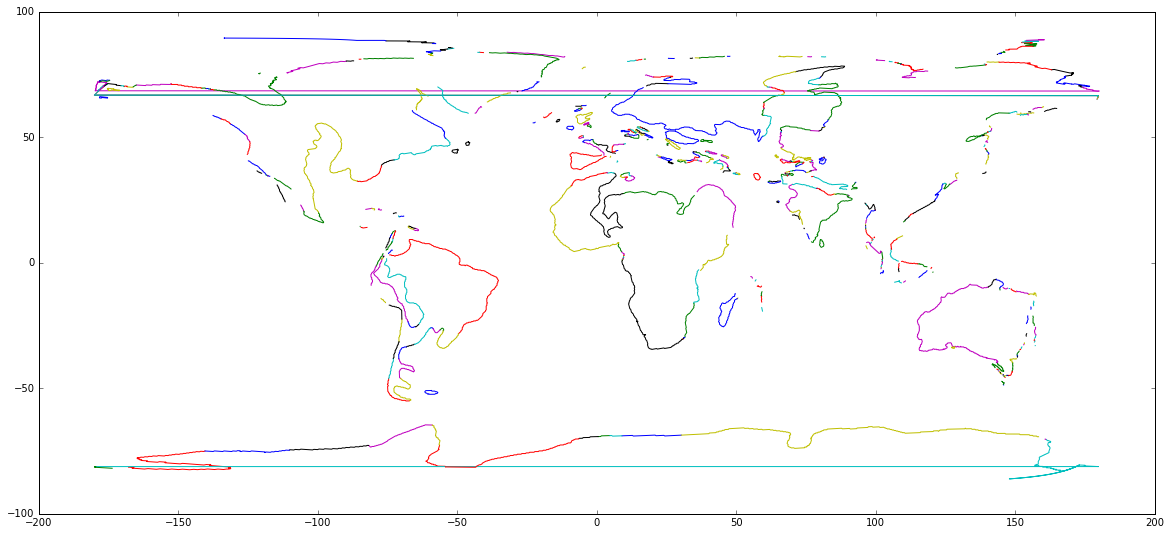

In [159]:
plt.figure(figsize=(20,9))

for feature in cc_features:
    #print feature.get_reconstruction_plate_id()
    if feature.get_reconstruction_plate_id() != 0:
        for geometry in feature.get_geometries():
            #print geometry
            if geometry is not None:
                plt.plot(geometry.to_lat_lon_array()[:,1],
                         geometry.to_lat_lon_array()[:,0])
        
